In [295]:
import numpy as np
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import sqrtm

# Regression

In [296]:
ambient_dimension = 128
avg_num = int(1e+1) # number of experiment average
noise_std = 0.5
factor = 0.8
snr = 4
sample_num = 70


# Data generation model:
# 1. 1-sparse vector
true_theta = np.zeros([ambient_dimension, 1])
signal_position = [0]
for i in signal_position:
    true_theta[i] = 1

# 2. random gaussian
# true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
# true_theta /= LA.norm(true_theta)
# true_theta = true_theta.reshape(-1, 1)

# 3. dense signal with spikes
#true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_theta[i] = 0
#spike_strength = 10000
#true_theta[0] = np.sqrt(spike_strength) * LA.norm(true_theta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
smallest_eig = .5  # choose 1 if you want uniform spectrum
decay = smallest_eig ** (1 / ambient_dimension)
decay = .95
off_diag_factor = 0
for i in range(ambient_dimension):
    #Sigma[i, i] = decay ** abs(i) if i in signal_position else 0
    Sigma[i, i] = decay ** abs(i)
for i in range(0, ambient_dimension, 2):
    Sigma[i+1, i] = off_diag_factor * Sigma[i, i]
    Sigma[i, i+1] = off_diag_factor * Sigma[i, i]

# 3. bi-level spectrum
# Sigma = np.identity(ambient_dimension)
# for i in range(int(ambient_dimension / 2), ambient_dimension):
#     Sigma[i, i] = smallest_eig

# 4. random spectrum
# Sigma = np.random.random((ambient_dimension, ambient_dimension))
# Sigma = Sigma.dot(Sigma.T)

alpha = snr * noise_std ** 2 / (true_theta.T.dot(Sigma).dot(true_theta)[0][0])
Sigma *= alpha

#for i in signal_position:
#    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in range(20):
#    Sigma[i, i] = 1
#for i in range(20, ambient_dimension):
#    Sigma[i, i] = 0.2

#for i in range(ambient_dimension):
#    Sigma[i, i] = random.random()

In [297]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_het_ridge_est(X, y, ridge_list):
    d = X.shape[1]
    n = X.shape[0]
    reg = n * np.identity(d)
    for i in range(d):
        reg[i, i] *= ridge_list[i]
    S = LA.pinv(X.T.dot(X) + reg).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_mask_lse_est(X, y):
    Cov = X.T.dot(X)
    n = X.shape[0]
    cov = np.diag(np.diag(Cov)) / n
    cov = sqrtm(cov)
    cov = LA.inv(cov)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = cov.dot(LA.pinv(cov.dot(Cov).dot(cov))).dot(cov).dot(X.T)
    return S.dot(y)

def get_rot_lse_est(X, y):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Cov = X.T.dot(X)
    n = X.shape[0]
    diag = np.diag(np.diag(Cov))
    cov = (np.trace(Cov) * np.identity(ambient_dimension) - Cov) * 4 / ambient_dimension
    cov = sqrtm(cov)
    cov = LA.inv(cov)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = cov.dot(LA.pinv(cov.dot(Cov).dot(cov))).dot(cov).dot(X.T)
    return S.dot(y)

def get_lse_est_2(X, y):
    Cov = X.T.dot(X)
    mu = X.mean(axis=0).reshape(-1, 1)
    n = X.shape[0]
    #Z1 = n * mu.dot(mu.T)
    Z1 = Cov - 0.5 * np.diag(np.diag(Cov))
    A1 = np.concatenate((Cov, Z1), axis=1)
    A2 = np.concatenate((Z1.T, Cov), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    #B = np.concatenate((X.T, mu.dot(np.ones([1, n]))), axis=0).dot(y)
    B = np.concatenate((X.T, X.T), axis=0).dot(y)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    return LA.pinv(Z).dot(B)

def get_knockoff_est(X, y, D):
    Cov = X.T.dot(X)
    A = Cov.dot(np.identity(ambient_dimension) - LA.inv(Sigma).dot(D))
    A1 = np.concatenate((Cov, A), axis=1)
    B = 2 * D - D.dot(LA.inv(Sigma)).dot(D) + Cov - Cov.dot(LA.inv(Sigma)).dot(D) - D.dot(LA.inv(Sigma)).dot(Cov) + \
        D.dot(LA.inv(Sigma)).dot(Cov).dot(LA.inv(Sigma)).dot(D)
    A2 = np.concatenate((A.T, B), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    C = np.concatenate((np.identity(ambient_dimension), np.identity(ambient_dimension) - D.dot(LA.inv(Sigma))), axis=0)
    return LA.pinv(Z).dot(C).dot(X.T).dot(y)

# def get_crop_est(X, y, p):
#     Cov = X.T.dot(X)
#     diag = np.diag(np.diag(Cov))
#     Z = Cov + p / (1 - p) * diag
#     S = LA.inv(Z).dot(X.T)
#     return S.dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    diag = np.diag(np.diag(Cov))
    #reg = np.trace(Cov) * np.identity(ambient_dimension) - Cov
    #Z = Cov + reg / ambient_dimension * 8 * p
    Z = Cov + p / (1 - p) * diag # + 0.41 * n * np.identity(ambient_dimension)
    S = LA.inv(Z).dot(X.T)
    # biased
    #return S.dot(y) / (1- p)
    # unbiased
    return S.dot(y)

def get_rotation_est(X, y, angle):
    angle = angle * np.pi /180
    Cov = X.T.dot(X)
    n = X.shape[0]
    diag = np.diag(np.diag(Cov))
    reg = np.trace(Cov) * np.identity(ambient_dimension) - Cov
    Z = Cov + reg / ambient_dimension * 4 * (1- np.cos(angle))
    #Z = Cov + p / (1 - p) * diag # + 0.41 * n * np.identity(ambient_dimension)
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_crop_est_bar(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = Cov + p / (1 - p) * n * Sigma
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

# heterogeneous mask
def get_het_crop_est(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    p1 = p / het_ratio
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    n = X.shape[0]
    p1 = p / het_ratio
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_risk(a, b):
    diff = a - b
    return  diff.T.dot(Sigma).dot(diff)[0, 0]

def get_norm(theta):
    return  theta.T.dot(Sigma).dot(theta)[0, 0]

In [298]:
# Choose the type of augmentation:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
#ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-10, -6, num=0)), np.power(2, np.linspace(-5, 2, num=10)), np.power(2, np.linspace(2, 20, num=0))))
ridge_params = np.concatenate((np.linspace(0.01, 2, 10), np.linspace(2.1, 10, 10), np.linspace(11, 100, 5) ))
ridge_params = np.power(2, np.linspace(-10, 10, 20))
for i in range(len(ridge_params)):
    ridge_params[i] = ridge_params[i] ** 2
#crop_params = np.concatenate((np.power(2, np.linspace(-10, -5, num=10)), np.linspace(0.01, 0.4, num=10), np.linspace(.5, .99, num=10)))
crop_params = np.linspace(0.001, 0.99, 20)
rot_params = np.linspace(5, 180, 20)

#ridge_params = [1]
#crop_params = [0.3]
#pepper_params = {"ridge": [1], "drop_prob": [0.3]}

In [299]:
risk_lse = np.zeros([avg_num])
bias_lse = np.zeros([avg_num])
var_lse = np.zeros([avg_num])

risk_lse_mask = np.zeros([avg_num])
bias_lse_mask = np.zeros([avg_num])
var_lse_mask = np.zeros([avg_num])

risk_lse_rot = np.zeros([avg_num])
bias_lse_rot = np.zeros([avg_num])
var_lse_rot = np.zeros([avg_num])

risk_ridge = np.zeros([avg_num, len(ridge_params)])
bias_ridge = np.zeros([avg_num, len(ridge_params)])
var_ridge = np.zeros([avg_num, len(ridge_params)])

risk_crop = np.zeros([avg_num, len(crop_params)])
bias_crop = np.zeros([avg_num, len(crop_params)])
var_crop = np.zeros([avg_num, len(crop_params)])
err_crop = np.zeros([avg_num, len(crop_params)])

risk_rot = np.zeros([avg_num, len(rot_params)])
bias_rot = np.zeros([avg_num, len(rot_params)])
var_rot = np.zeros([avg_num, len(rot_params)])


# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X_tr = np.zeros([sample_num, ambient_dimension])
    y_tr = np.zeros([sample_num, 1])
    noise_tr = np.zeros([sample_num, 1])
    for j in range(X_tr.shape[0]):
        X_tr[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        noise_tr[j, :] = np.random.normal(0, noise_std)
        y_tr[j, :] = np.inner(true_theta.reshape(-1), X_tr[j, :]) + noise_tr[j, :]

    theta_lse = get_lse_est(X_tr, y_tr)
    theta_lse_bias = get_lse_est(X_tr, y_tr - noise_tr)
    theta_lse_var = get_lse_est(X_tr, noise_tr)

    risk_lse[i] = get_risk(theta_lse, true_theta)
    bias_lse[i] = get_risk(theta_lse_bias, true_theta)
    var_lse[i] = get_risk(0, theta_lse_var)

    theta_lse_mask = get_mask_lse_est(X_tr, y_tr)
    theta_lse_bias_mask = get_mask_lse_est(X_tr, y_tr - noise_tr)
    theta_lse_var_mask = get_mask_lse_est(X_tr, noise_tr)

    risk_lse_mask[i] = get_risk(theta_lse_mask, true_theta)
    bias_lse_mask[i] = get_risk(theta_lse_bias_mask, true_theta)
    var_lse_mask[i] = get_risk(0, theta_lse_var_mask)

    theta_lse_rot = get_rot_lse_est(X_tr, y_tr)
    theta_lse_bias_rot = get_rot_lse_est(X_tr, y_tr - noise_tr)
    theta_lse_var_rot = get_rot_lse_est(X_tr, noise_tr)

    risk_lse_rot[i] = get_risk(theta_lse_rot, true_theta)
    bias_lse_rot[i] = get_risk(theta_lse_bias_rot, true_theta)
    var_lse_rot[i] = get_risk(0, theta_lse_var_rot)

    # get loss
    for j in range(len(ridge_params)):
        theta = get_ridge_est(X_tr, y_tr, ridge_params[j])
        theta_bias = get_ridge_est(X_tr, y_tr - noise_tr, ridge_params[j])
        theta_var = get_ridge_est(X_tr, noise_tr, ridge_params[j])
        risk_ridge[i, j] = get_risk(theta, true_theta)
        bias_ridge[i, j] = get_risk(theta_bias, true_theta)
        var_ridge[i, j] = get_risk(theta_var, 0)
    for j in range(len(rot_params)):
        theta = get_rotation_est(X_tr, y_tr, rot_params[j])
        theta_bias = get_rotation_est(X_tr, y_tr - noise_tr, rot_params[j])
        theta_var = get_rotation_est(X_tr, noise_tr, rot_params[j])
        risk_rot[i, j] = get_risk(theta, true_theta)
        bias_rot[i, j] = get_risk(theta_bias, true_theta)
        var_rot[i, j] = get_risk(theta_var, 0)
    for j in range(len(crop_params)):
        theta = get_crop_est(X_tr, y_tr, crop_params[j])
        theta_bias = get_crop_est(X_tr, y_tr - noise_tr, crop_params[j])
        theta_var = get_crop_est(X_tr, noise_tr, crop_params[j])
        theta_bar = get_crop_est_bar(X_tr, y_tr, crop_params[j])
        risk_crop[i, j] = get_risk(theta, true_theta)
        bias_crop[i, j] = get_risk(theta_bias, true_theta)
        var_crop[i, j] = get_risk(theta_var, 0)
        err_crop[i, j] = get_risk(theta, theta_bar)

risk_ridge = np.mean(risk_ridge, axis=0)
bias_ridge = np.mean(bias_ridge, axis=0)
var_ridge = np.mean(var_ridge, axis=0)
risk_rot = np.mean(risk_rot, axis=0)
bias_rot = np.mean(bias_rot, axis=0)
var_rot = np.mean(var_rot, axis=0)
risk_crop = np.mean(risk_crop, axis=0)
bias_crop = np.mean(bias_crop, axis=0)
var_crop = np.mean(var_crop, axis=0)
err_crop = np.mean(err_crop, axis=0)
risk_lse = np.mean(risk_lse, axis=0)
bias_lse = np.mean(bias_lse, axis=0)
var_lse = np.mean(var_lse, axis=0)
risk_lse_mask = np.mean(risk_lse_mask, axis=0)
bias_lse_mask = np.mean(bias_lse_mask, axis=0)
var_lse_mask = np.mean(var_lse_mask, axis=0)
risk_lse_rot = np.mean(risk_lse_rot, axis=0)
bias_lse_rot = np.mean(bias_lse_rot, axis=0)
var_lse_rot = np.mean(var_lse_rot, axis=0)


#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

 10%|█         | 1/10 [00:00<00:07,  1.13it/s]/var/folders/07/2gbk01xd17j180_jn3r604th0000gn/T/ipykernel_77714/2674842803.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  risk_lse_rot[i] = get_risk(theta_lse_rot, true_theta)
/var/folders/07/2gbk01xd17j180_jn3r604th0000gn/T/ipykernel_77714/2674842803.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  bias_lse_rot[i] = get_risk(theta_lse_bias_rot, true_theta)
/var/folders/07/2gbk01xd17j180_jn3r604th0000gn/T/ipykernel_77714/2674842803.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  var_lse_rot[i] = get_risk(0, theta_lse_var_rot)
100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Complete in 5.57 sec


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0.5, 1.0, 'Random Rotation ($\\alpha$)')

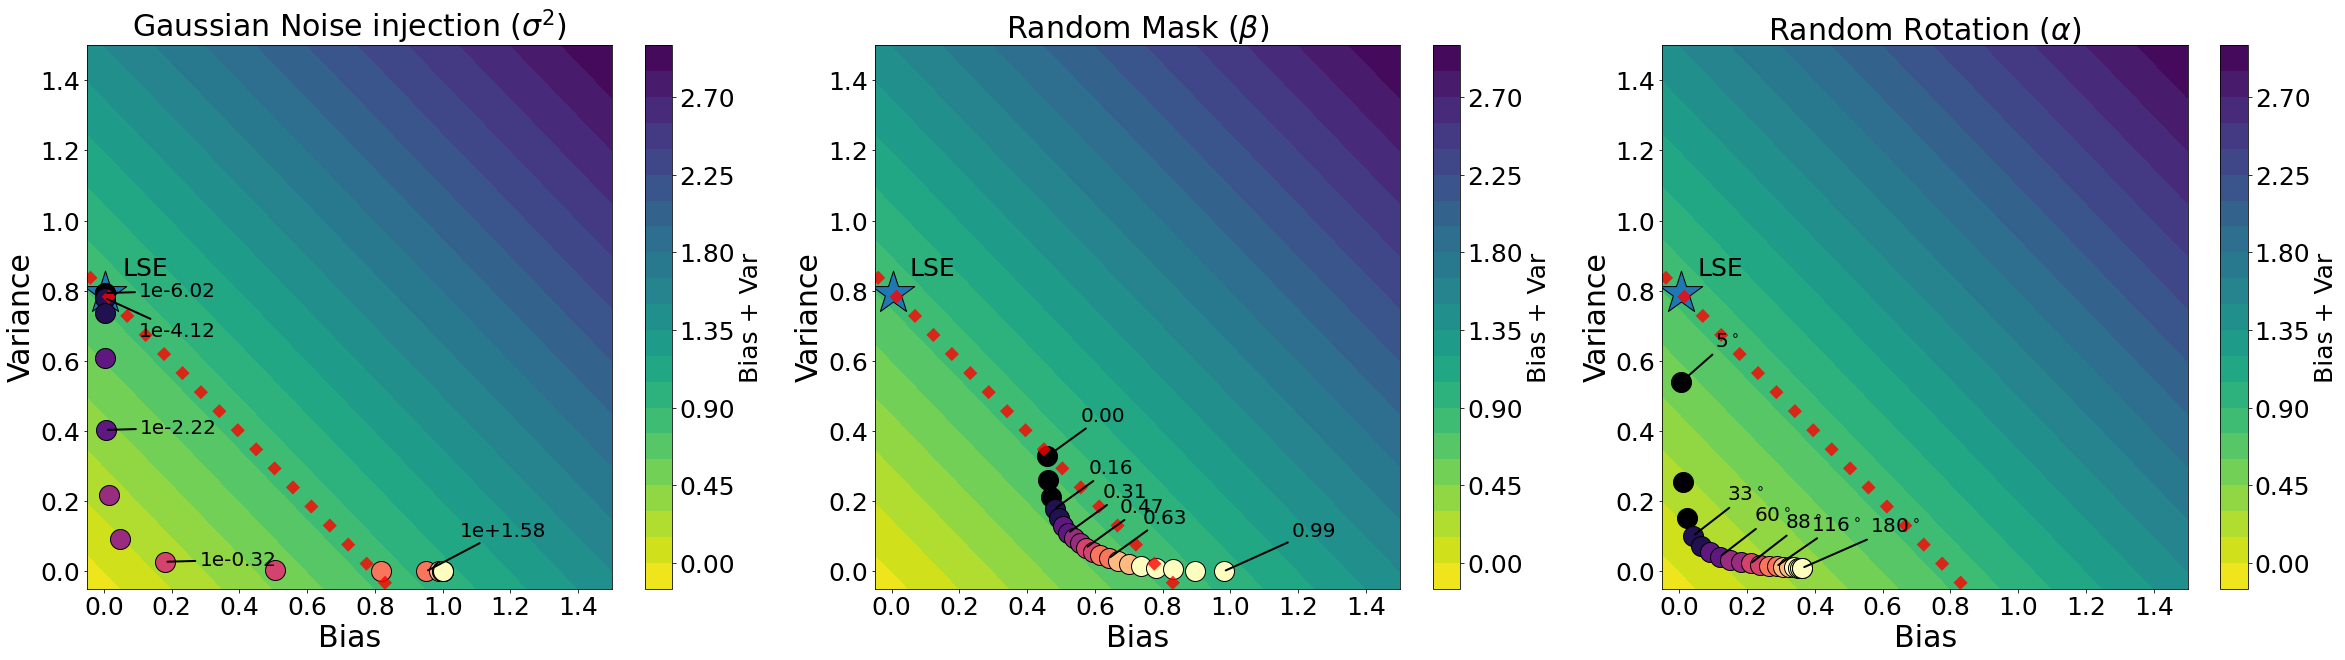

In [300]:
from matplotlib import cm

fontsize = 20
linewidth = 2.0
tick_size = 25
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap('viridis', 8)
plasma = cm.get_cmap('plasma', 8)
lse_color = viridis(-100)
y_min, y_max = 0.2, 1
markersize = 8
size_factor = 100
alpha = 1

def mse(x, y):
    return x + y
color1 = 'magma'
color2 = 'viridis_r'
color3 = 'plasma'
linewidth = 2.0
tick_size = 25
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap(color1, 8)
plasma = cm.get_cmap(color1, 8)
lse_color = viridis(-100)
x_min, x_max = -0.05, 1.5
y_min, y_max = -0.05, 1.5
X, Y = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
Z = mse(X, Y)
# plt.contourf(X, Y, Z, 20, cmap='viridis')
# plt.colorbar()
# markersize = 8

import matplotlib.patches as patches
size_factor = 100
style = "Simple, tail_width=0.5, head_width=20, head_length=15"
kw = dict(arrowstyle=style, color="k")


plt.figure(figsize=(40, 10))
ax = plt.subplot(1, 3, 1)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=20)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='red')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask , var_lse_mask +0.1, s='M-LSE', fontsize=25)
size_vec = ridge_params
for i in range(len(ridge_params)):
    #plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=3000 * np.sqrt(size_vec[i]))
    plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=400, edgecolors='k')
    #if i > 0:
    #    plt.plot([bias_ridge[i-1], bias_ridge[i]], [var_ridge[i-1], var_ridge[i]], c='black', linestyle='-')
    #plt.text(bias_ridge[i], var_ridge[i], s=format(np.sign(ridge_params[i]) * round(np.sqrt(np.abs(ridge_params[i])),3), '.2f'), fontsize=22, rotation=40, color="red")
    #if i % 3 == 0:
        #plt.text(bias_ridge[i], var_ridge[i], s=format(np.sign(ridge_params[i]) * round(np.sqrt(np.abs(ridge_params[i])),3), '.2f'), fontsize=22, rotation=40, #color="red")
for j in range(0,len(ridge_params) - 5, 3):
    expo = round(np.log10(ridge_params[j]),3)
    off_x = 0
    off_y = 0
    if expo >= 0:
        ax.annotate('1e+' + format(round(np.log10(ridge_params[j]),3), '.2f'), xy =(bias_ridge[j], var_ridge[j]),
                        xytext =(bias_ridge[j] + 0.1, var_ridge[j] + 0.1),
                        arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
    else:
        if j == 3:
            off_y = -0.1
        ax.annotate('1e' + format(round(np.log10(ridge_params[j]),3), '.2f'), xy =(bias_ridge[j], var_ridge[j]),
                        xytext =(bias_ridge[j] + 0.1 + off_x, var_ridge[j]+off_y - 0.01),
                        arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
#j = -1
#ax.annotate('1e+' + format(round(np.log10(ridge_params[j]),3), '.2f'), xy =(bias_ridge[j], var_ridge[j]),
#                    xytext =(bias_ridge[j] + 0.2, var_ridge[j] + 0.1),
#                    arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 + 0.05, (bias_lse + var_lse)/2 + 0.05), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle=':', linewidth=10, alpha=0.8, color='red')
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Gaussian Noise injection '+r'($\sigma^2$)', fontsize=30)

ax = plt.subplot(1, 3, 2)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=20)
#cb.ax.set_ylabel('Bias + Var', fontsize=25)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask - 0.2, var_lse_mask +0.1, s='M-LSE', fontsize=25)
size_vec = crop_params
for i in range(len(crop_params)):
    #plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=3000 * (size_vec[i]))
    plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k')
    # if i > 0:
    #     plt.plot([bias_crop[i-1], bias_crop[i]], [var_crop[i-1], var_crop[i]], c='black', linestyle='-')
    # if i % 3 == 0:
    #     plt.text(bias_crop[i]+0.02, var_crop[i]+0.02, s=format(round(crop_params[i],3), '.2f'), fontsize=22, rotation=40, color="red")
for j in range(0,len(crop_params) - 5, 3):
    ax.annotate(format(round(crop_params[j],3), '.2f'), xy =(bias_crop[j], var_crop[j]),
                    xytext =(bias_crop[j] + 0.1, var_crop[j] + 0.1),
                    arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
j = -1
ax.annotate(format(round(crop_params[j],3), '.2f'), xy =(bias_crop[j], var_crop[j]),
                    xytext =(bias_crop[j] + 0.2, var_crop[j] + 0.1),
                    arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)

# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k",alpha=1),
#             xy=((bias_lse + var_lse)/2 + 0.02, (bias_lse + var_lse)/2 + 0.02), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k", alpha=1),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle=':', linewidth=10, alpha=0.8, color='red')
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Random Mask '+r'($\beta$)', fontsize=30)


ax = plt.subplot(1, 3, 3)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1)
plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask - 0.2, var_lse_mask +0.1, s='M-LSE', fontsize=25)
#plt.scatter(bias_lse_rot, var_lse_rot, s=1000, marker='*', facecolors='none', edgecolors='black', linewidths=4)
#plt.text(bias_lse_rot + 0.05, var_lse_rot - 0.02, s='R-LSE', fontsize=25)
size_vec = rot_params
for i in range(len(rot_params)):
    #plt.scatter(bias_rot[i], var_rot[i], c=viridis(i/len(rot_params)*1.2), s=10*(size_vec[i]))
    plt.scatter(bias_rot[i], var_rot[i], c=viridis((i)/len(rot_params)*1.2), edgecolors='k', s=400, alpha=alpha)
    #if i > 0:
    #    plt.plot([bias_rot[i-1], bias_rot[i]], [var_rot[i-1], var_rot[i]], c='black', linestyle='-')
    # if i % 3 == 0:
    #     plt.text(bias_rot[i] + 0.02, var_rot[i] + 0.02, s=format(round(rot_params[i])), fontsize=22, rotation=40, color="red")
#a = patches.FancyArrowPatch((bias_rot[0], var_rot[0]), (bias_rot[-1]+0.2, var_rot[-1]),
#                             connectionstyle="arc3,rad=.55", **kw)
for j in range(0,len(rot_params) - 5, 3):
    off_x = 0
    off_y = 0
    ax.annotate(format(round(rot_params[j],3), '.0f')+r'$^\circ$', xy =(bias_rot[j], var_rot[j]),
                        xytext =(bias_rot[j] + 0.1 + off_x, var_rot[j] + 0.1 + off_y),
                        arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
j = -1
ax.annotate(format(round(rot_params[j],3), '.0f')+r'$^\circ$', xy =(bias_rot[j], var_rot[j]),
                    xytext =(bias_rot[j] + 0.2, var_rot[j] + 0.1),
                    arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
#ax.annotate('Harmful', xy =((bias_lse + var_lse) / 2, (bias_lse + var_lse) / 2),
#                    xytext =((bias_lse + var_lse) / 2 + 0.02, (bias_lse + var_lse) / 2+0.2),
#                    arrowprops = {'arrowstyle': '<-', 'lw': 10}, fontsize=fontsize)
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle=':', linewidth=10, alpha=0.8, color='red')
#plt.text((bias_lse + var_lse)/2 + 0.1, (bias_lse + var_lse)/2 + 0.1, s='Harmful', fontsize=30)
# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 + 0.05, (bias_lse + var_lse)/2 + 0.05), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
#plt.gca().add_patch(a)
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Random Rotation '+r'($\alpha$)', fontsize=30)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0.5, 1.0, 'Random Rotation ($\\alpha$)')

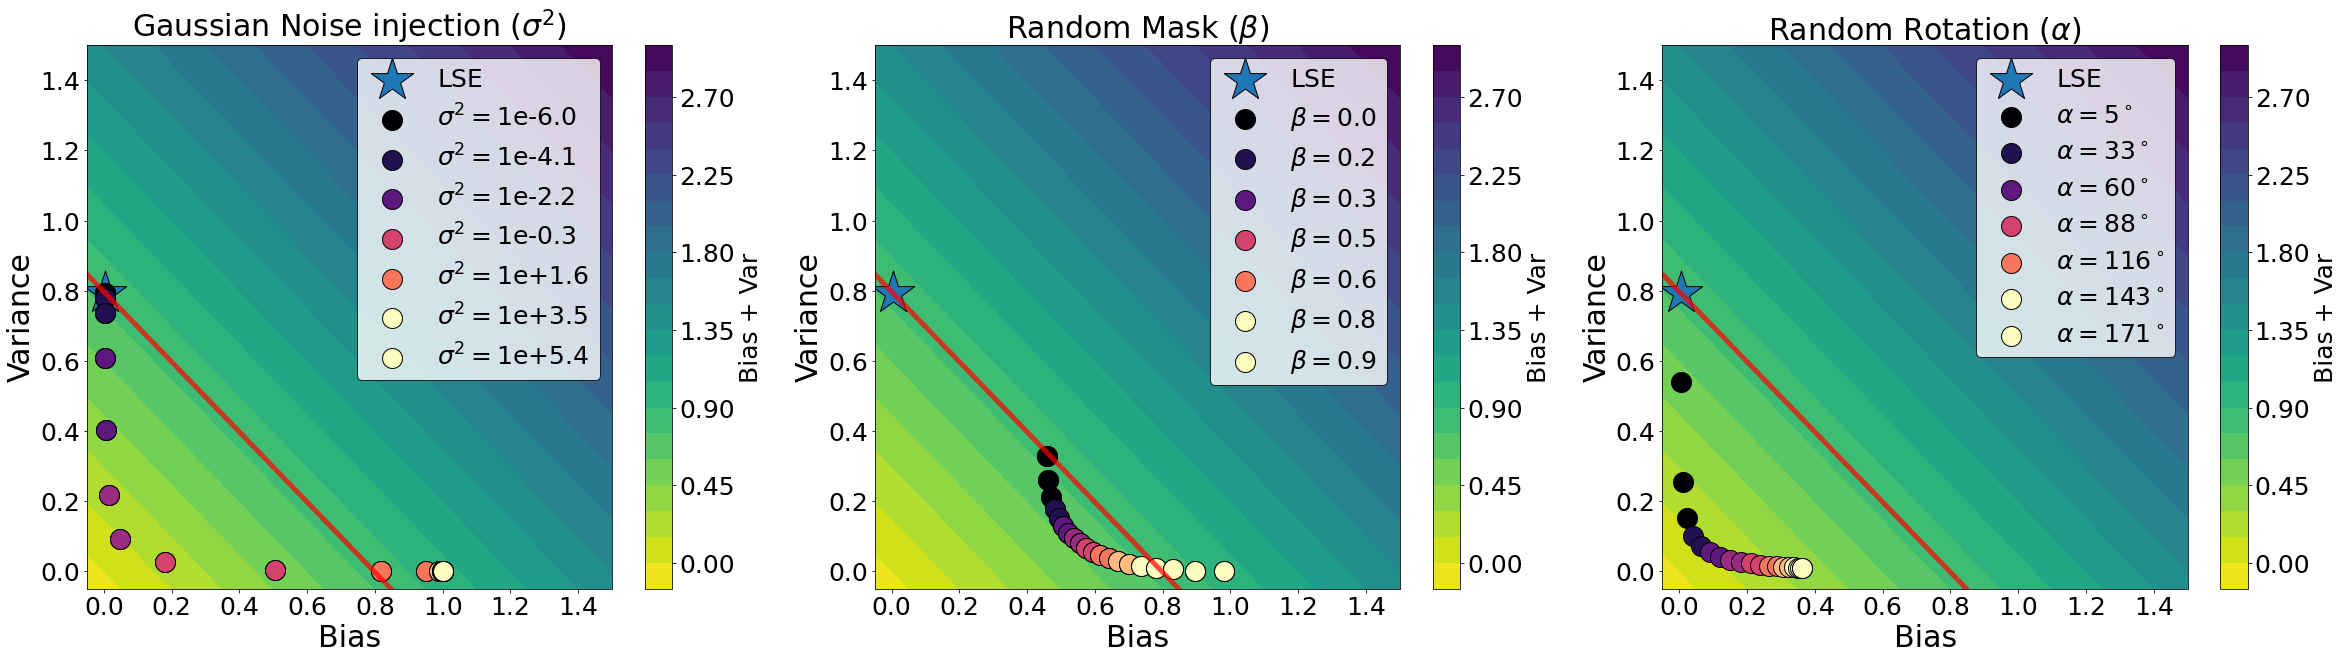

In [301]:
from matplotlib import cm

fontsize = 20
linewidth = 2.0
tick_size = 25
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap('viridis', 8)
plasma = cm.get_cmap('plasma', 8)
lse_color = viridis(-100)
y_min, y_max = 0.2, 1
markersize = 8
size_factor = 100
alpha = 1

def mse(x, y):
    return x + y
color1 = 'magma'
color2 = 'viridis_r'
color3 = 'plasma'
linewidth = 2.0
tick_size = 25
markersize = 8
title_name = 'Uniform Spectrum'
viridis = cm.get_cmap(color1, 8)
plasma = cm.get_cmap(color1, 8)
lse_color = viridis(-100)
x_min, x_max = -0.05, 1.5
y_min, y_max = -0.05, 1.5
legendsize= 25
X, Y = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
Z = mse(X, Y)
# plt.contourf(X, Y, Z, 20, cmap='viridis')
# plt.colorbar()
# markersize = 8

import matplotlib.patches as patches
size_factor = 100
style = "Simple, tail_width=0.5, head_width=20, head_length=15"
kw = dict(arrowstyle=style, color="k")


plt.figure(figsize=(40, 10))
ax = plt.subplot(1, 3, 1)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=20)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1, label='LSE')
#plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='red')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask , var_lse_mask +0.1, s='M-LSE', fontsize=25)
size_vec = ridge_params
for i in range(len(ridge_params)):
    #plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=3000 * np.sqrt(size_vec[i]))
    plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=400, edgecolors='k')
    if i % 3 == 0:
        #plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k', label=r'$\beta=$' + format(round(crop_params[i],3), '.1f'))
        c = ''
        if round(np.log10(ridge_params[i]),2) >= 0:
            c = '+'
        plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=400, edgecolors='k', label=r'$\sigma^2=$'+'1e'+c+format(round(np.log10(ridge_params[i]),2), '.1f'))
    else:
        plt.scatter(bias_ridge[i], var_ridge[i], c=viridis(i/len(ridge_params)*1.2), s=400, edgecolors='k')
    #if i > 0:
    #    plt.plot([bias_ridge[i-1], bias_ridge[i]], [var_ridge[i-1], var_ridge[i]], c='black', linestyle='-')
    #plt.text(bias_ridge[i], var_ridge[i], s=format(np.sign(ridge_params[i]) * round(np.sqrt(np.abs(ridge_params[i])),3), '.2f'), fontsize=22, rotation=40, color="red")
    #if i % 3 == 0:
        #plt.text(bias_ridge[i], var_ridge[i], s=format(np.sign(ridge_params[i]) * round(np.sqrt(np.abs(ridge_params[i])),3), '.2f'), fontsize=22, rotation=40, #color="red")

#j = -1
#ax.annotate('1e+' + format(round(np.log10(ridge_params[j]),3), '.2f'), xy =(bias_ridge[j], var_ridge[j]),
#                    xytext =(bias_ridge[j] + 0.2, var_ridge[j] + 0.1),
#                    arrowprops = {'arrowstyle': '-', 'lw': 2}, fontsize=fontsize)
# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 + 0.05, (bias_lse + var_lse)/2 + 0.05), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle='-', linewidth=5, alpha=.7, color='red')
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Gaussian Noise injection '+r'($\sigma^2$)', fontsize=30)

ax = plt.subplot(1, 3, 2)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=20)
#cb.ax.set_ylabel('Bias + Var', fontsize=25)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1, label='LSE')
#plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask - 0.2, var_lse_mask +0.1, s='M-LSE', fontsize=25)
size_vec = crop_params
for i in range(len(crop_params)):
    #plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=3000 * (size_vec[i]))
    plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k')
    if i % 3 == 0:
        plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k', label=r'$\beta=$' + format(round(crop_params[i],3), '.1f'))
    else:
        plt.scatter(bias_crop[i], var_crop[i], c=viridis(i/len(crop_params)*1.2), s=400, edgecolors='k')

    # if i > 0:
    #     plt.plot([bias_crop[i-1], bias_crop[i]], [var_crop[i-1], var_crop[i]], c='black', linestyle='-')
    # if i % 3 == 0:
    #     plt.text(bias_crop[i]+0.02, var_crop[i]+0.02, s=format(round(crop_params[i],3), '.2f'), fontsize=22, rotation=40, color="red")


# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k",alpha=1),
#             xy=((bias_lse + var_lse)/2 + 0.02, (bias_lse + var_lse)/2 + 0.02), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k", alpha=1),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle='-', linewidth=5, alpha=.7, color='red')
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Random Mask '+r'($\beta$)', fontsize=30)


ax = plt.subplot(1, 3, 3)
plt.contourf(X, Y, Z, 20, cmap=color2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel('Bias + Var', fontsize=25)
plt.scatter(bias_lse, var_lse, s=2000, marker='*', facecolors='#1f77b4', edgecolors='k', linewidths=1,label='LSE')
#plt.text(bias_lse + 0.05, var_lse + 0.05, s='LSE', fontsize=25, c='k')
#plt.scatter(bias_lse_mask, var_lse_mask, s=2000, marker='*', facecolors='tomato', edgecolors='black', linewidths=1)
#plt.text(bias_lse_mask - 0.2, var_lse_mask +0.1, s='M-LSE', fontsize=25)
#plt.scatter(bias_lse_rot, var_lse_rot, s=1000, marker='*', facecolors='none', edgecolors='black', linewidths=4)
#plt.text(bias_lse_rot + 0.05, var_lse_rot - 0.02, s='R-LSE', fontsize=25)
size_vec = rot_params
for i in range(len(rot_params)):
    #plt.scatter(bias_rot[i], var_rot[i], c=viridis(i/len(rot_params)*1.2), s=10*(size_vec[i]))
    if i % 3 == 0:
        plt.scatter(bias_rot[i], var_rot[i], c=viridis((i)/len(rot_params)*1.2), edgecolors='k', s=400, alpha=alpha, label=r'$\alpha=$' + format(round(rot_params[i],3), '.0f')+r'$^\circ$')
    else:
        plt.scatter(bias_rot[i], var_rot[i], c=viridis((i)/len(rot_params)*1.2), edgecolors='k', s=400, alpha=alpha)
    #if i > 0:
    #    plt.plot([bias_rot[i-1], bias_rot[i]], [var_rot[i-1], var_rot[i]], c='black', linestyle='-')
    # if i % 3 == 0:
    #     plt.text(bias_rot[i] + 0.02, var_rot[i] + 0.02, s=format(round(rot_params[i])), fontsize=22, rotation=40, color="red")
#a = patches.FancyArrowPatch((bias_rot[0], var_rot[0]), (bias_rot[-1]+0.2, var_rot[-1]),
#                             connectionstyle="arc3,rad=.55", **kw)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
plt.plot([-0.05, bias_lse + var_lse + 0.05], [bias_lse + var_lse + 0.05, -0.05], linestyle='-', linewidth=5, alpha=.7, color='red')
#plt.text((bias_lse + var_lse)/2 + 0.1, (bias_lse + var_lse)/2 + 0.1, s='Harmful', fontsize=30)
# ax.annotate("Harmful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 + 0.05, (bias_lse + var_lse)/2 + 0.05), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
# ax.annotate("Helpful",
#             bbox=dict(boxstyle="round", fc="white", ec="k"),
#             xy=((bias_lse + var_lse)/2 - 0.15, (bias_lse + var_lse)/2 - 0.15), textcoords='offset points', ha='center',fontsize=25, rotation = 315
#             )
#plt.gca().add_patch(a)
plt.xlabel('Bias', fontsize=30)
plt.ylabel('Variance', fontsize=30)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Random Rotation '+r'($\alpha$)', fontsize=30)